In [1]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

In [2]:
import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

In [3]:
path = '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data'
filenames = []

for root, _, files in os.walk(path, topdown=False):
    for name in files:
        filenames.append(os.path.join(root, name))

set(filenames)

{'/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Climbing_stairs.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Descending_stairs.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Desk_work.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Falling_on_the_back.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Falling_on_the_knees.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Falling_on_the_left.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Falling_on_the_right.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Lying_down_left.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Lying_down_on_back.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Practical/Kai_Respeck_data/Lying_down_on_right.csv',
 '/afs/inf.ed.ac.uk/user/s18/s1894401/PDIoT/Pract

In [4]:
dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename))

In [ ]:
Kai_df = pd.concat(dataframes).reset_index(drop=True)
Kai_df

In [6]:
base_df = pd.read_csv('Respeck_recordings_clean.csv')
movement_indices = np.asarray(base_df[base_df.activity_type == 'Movement'].index) # drop general movement
base_df.drop(movement_indices, inplace=True)
base_df.reset_index(drop=True, inplace=True)

/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# cleaning data
df_respeck = base_df[(base_df['activity_type']=='Standing') & (base_df['accel_y'] < -0.5)]
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Walking at normal speed') & (base_df['accel_y'] < 0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Climbing stairs') & (base_df['accel_y'] < 0)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Desk work') & (base_df['accel_y'] < -0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting') & (base_df['accel_y'] < -0.5)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting bent forward') & (base_df['accel_y'] < -0.25)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Sitting bent backward') & (base_df['accel_y'] < 0)]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down on back')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down on stomach')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down left')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Lying down right')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the left')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the right')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on knees')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Falling on the back')]])
df_respeck = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Running')]])
base_df = pd.concat([df_respeck, base_df[(base_df['activity_type']=='Descending stairs') & (base_df['accel_x'] > -0.5) & (base_df['accel_y'] < 0.5)]])
base_df.reset_index(inplace=True)

In [8]:
base_df.activity_type.unique()

array(['Standing', 'Walking at normal speed', 'Climbing stairs',
       'Desk work', 'Sitting', 'Sitting bent forward',
       'Sitting bent backward', 'Lying down on back',
       'Lying down on stomach', 'Lying down left', 'Lying down right',
       'Falling on the left', 'Falling on the right', 'Falling on knees',
       'Falling on the back', 'Running', 'Descending stairs'],
      dtype=object)

In [9]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [10]:
falling_dfs = []
for _ in range(10):
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on knees'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the right'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the left'])
    falling_dfs.append(base_df[base_df.activity_type == 'Falling on the back'])

falling_df = pd.concat(falling_dfs).reset_index(drop=True)

running_dfs = []
for _ in range(2):
    running_dfs.append(base_df[base_df.activity_type == 'Running'])

running_df = pd.concat(running_dfs).reset_index(drop=True)

In [11]:
base_df = pd.concat([base_df, falling_df, running_df]).reset_index(drop=True)

In [12]:
nan_indices = set()
for i in range(len(base_df)):
    for col in columns_of_interest:
        if pd.isnull(base_df.loc[i, col]):
            nan_indices.add(i)

In [13]:
base_df.drop(list(nan_indices), inplace=True)

In [14]:
subject_dataframes = []

In [15]:
for rid, group in base_df.groupby("subject_id"):
    subject_dataframes.append(group)

In [16]:
n = len(subject_dataframes)
n

46

In [17]:
# Get the final sliding windows for the whole dataset

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
    # print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    if len(overlapping_windows) == 0:
            continue
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))


final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
subject_ids = list(set(base_df['subject_id']))
training_partitions = [final_sliding_windows[final_sliding_windows.subject_id != s] for s in subject_ids]
testing_partitions = [final_sliding_windows[final_sliding_windows.subject_id == s] for s in subject_ids]

/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/afs/inf.ed.ac.uk/user/s18/s1894401/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
# Get the final sliding windows for Kai's dataset

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in Kai_df.groupby("recording_id"):
    # print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    if len(overlapping_windows) == 0:
            continue
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))


Kai_final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
Kai_final_sliding_windows

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,window_id
0,1632922547206,0.015137,-0.638733,-0.106506,6.609375,2.500000,3.171875,Respeck,Climbing stairs,12,s1800883,NaN,Respeck_s1800883_Climbing stairs_29-09-2021_14...,0
1,1632922547235,0.036621,-0.818176,-0.220764,3.687500,-4.812500,1.453125,Respeck,Climbing stairs,12,s1800883,NaN,Respeck_s1800883_Climbing stairs_29-09-2021_14...,0
2,1632922547281,-0.022949,-1.087952,-0.211731,-1.609375,-5.156250,-10.078125,Respeck,Climbing stairs,12,s1800883,NaN,Respeck_s1800883_Climbing stairs_29-09-2021_14...,0
3,1632922547327,0.006592,-1.313293,-0.159973,-8.921875,-0.218750,-11.781250,Respeck,Climbing stairs,12,s1800883,NaN,Respeck_s1800883_Climbing stairs_29-09-2021_14...,0
4,1632922547356,0.017090,-1.298401,-0.305969,-19.750000,-6.578125,-5.171875,Respeck,Climbing stairs,12,s1800883,NaN,Respeck_s1800883_Climbing stairs_29-09-2021_14...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21545,1632922757865,-0.147949,-0.588928,0.024109,-2.093750,1.921875,3.421875,Respeck,Walking at normal speed,1,s1800883,NaN,Respeck_s1800883_Walking at normal speed_29-09...,430
21546,1632922757895,-0.030273,-0.487610,0.102478,1.625000,10.765625,6.921875,Respeck,Walking at normal speed,1,s1800883,NaN,Respeck_s1800883_Walking at normal speed_29-09...,430
21547,1632922757940,-0.013916,-0.632141,0.171570,-0.796875,9.343750,6.328125,Respeck,Walking at normal speed,1,s1800883,NaN,Respeck_s1800883_Walking at normal speed_29-09...,430
21548,1632922757985,-0.056885,-0.693665,0.179626,-0.781250,16.500000,0.484375,Respeck,Walking at normal speed,1,s1800883,NaN,Respeck_s1800883_Walking at normal speed_29-09...,430


In [ ]:
############################ Static postures superclass #####################################

Deviation is 0.029483683292009948


106.6880109353994

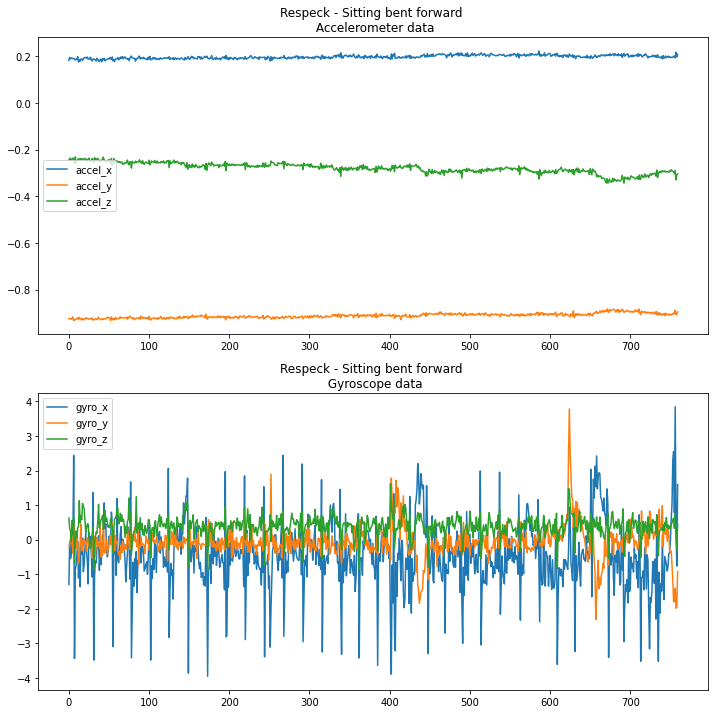

In [19]:
df_respeck = Kai_df[Kai_df.activity_type == 'Sitting bent forward'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

print('Deviation is', np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
theta_z

Deviation is 0.018710611571772756


53.68955121310231

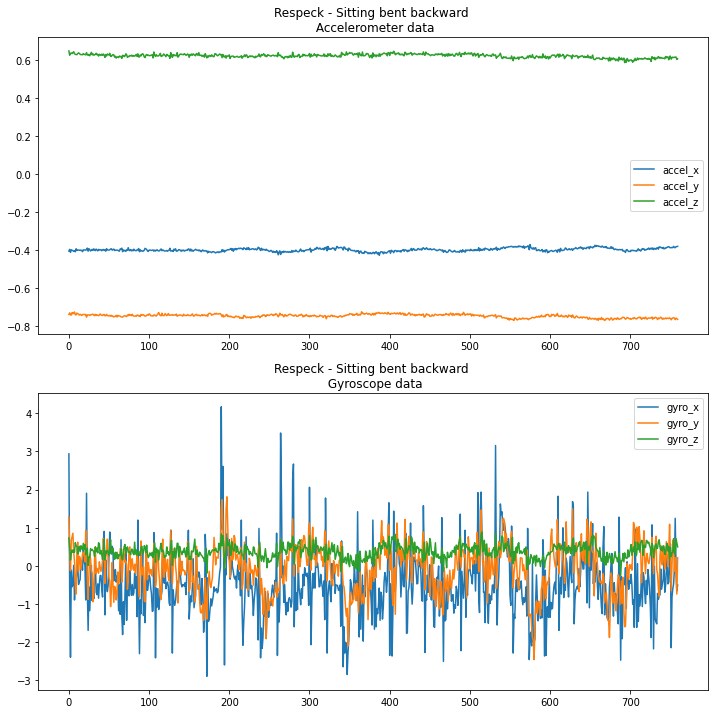

In [20]:
df_respeck = Kai_df[Kai_df.activity_type == 'Sitting bent backward'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

print('Deviation is', np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
theta_z

Deviation is 0.03337241926132099


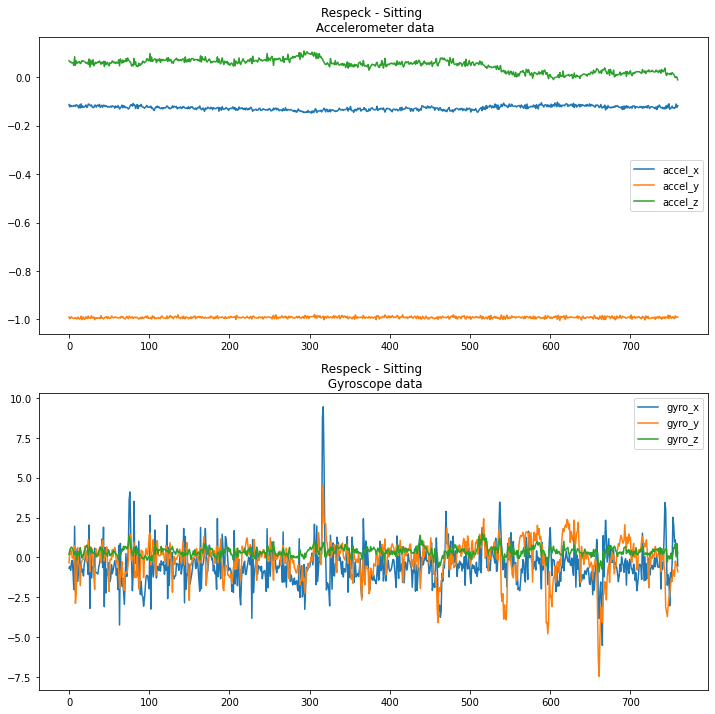

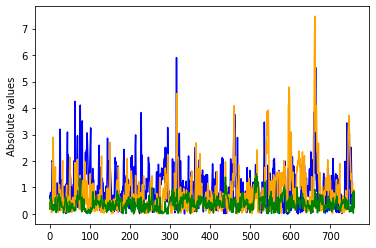

SMA is: 0.8279399671052632


87.14455161572188

In [21]:
df_respeck = Kai_df[Kai_df.activity_type == 'Sitting'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

print('Deviation is', np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))

# take absolute value
filtered_gyro_x = [abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0]
filtered_gyro_y = [abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0]
filtered_gyro_z = [abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0]

lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)

plt.figure()
plt.plot(filtered_gyro_x, c='b')
plt.plot(filtered_gyro_y, color='orange')
plt.plot(filtered_gyro_z, color='green')
plt.ylabel('Absolute values')
plt.show()

print('SMA is:', sum(filtered_gyro_y)/ly)

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
theta_z

Deviation is 0.01967973288577716


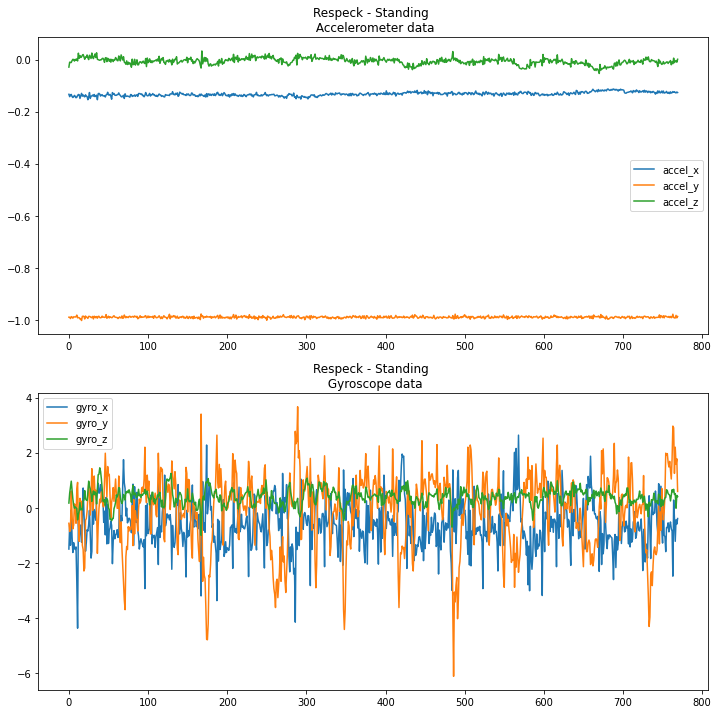

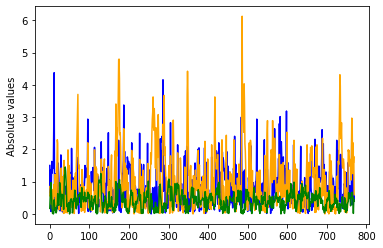

SMA is: 0.9967938311688311


90.35623159525574

In [22]:
df_respeck = Kai_df[Kai_df.activity_type == 'Standing'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

print('Deviation is', np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))

# take absolute value
filtered_gyro_x = np.array([abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0])
filtered_gyro_y = np.array([abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0])
filtered_gyro_z = np.array([abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0])

lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)

plt.figure()
plt.plot(filtered_gyro_x, c='b')
plt.plot(filtered_gyro_y, color='orange')
plt.plot(filtered_gyro_z, color='g')
plt.ylabel('Absolute values')
plt.show()

print('SMA is:', sum(filtered_gyro_y)/ly)

cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
theta_z

Text(0.5, 1.0, 'Respeck - Standing \n Gyroscope data')

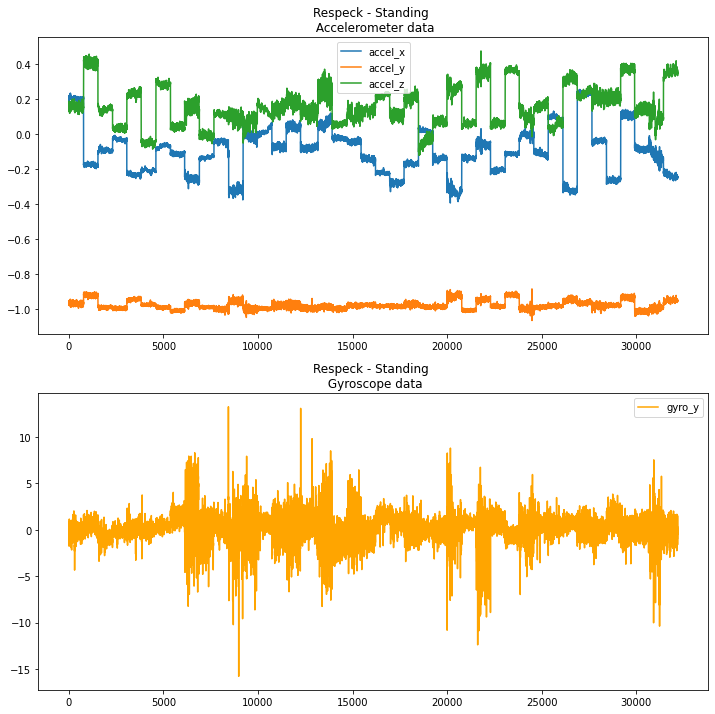

In [23]:
df_respeck = base_df[base_df.activity_type == 'Standing'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y", color='orange')
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

Text(0.5, 1.0, 'Respeck - Sitting \n Gyroscope data')

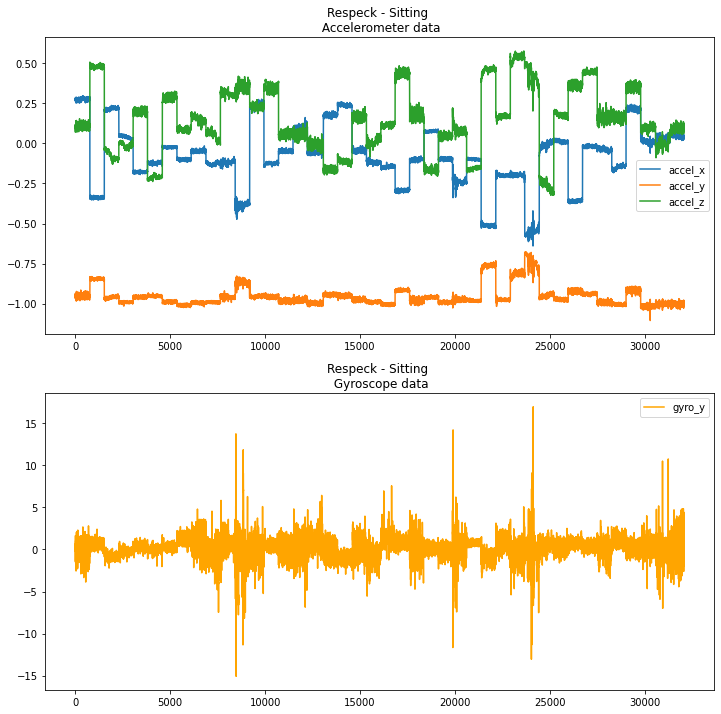

In [24]:
df_respeck = base_df[base_df.activity_type == 'Sitting'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y", color='orange')
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

In [25]:
df_respeck = base_df[base_df.activity_type == 'Standing'].reset_index(drop=True)

# take absolute value
filtered_gyro_x = np.array([abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0])
filtered_gyro_y = np.array([abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0])
filtered_gyro_z = np.array([abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0])

lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)

# compute sum of average SMAs for gyro_x, gyro_y and gyro_z
print('SMA is:', sum(filtered_gyro_y)/ly)


SMA is: 0.9097801594794765


In [26]:
df_respeck = base_df[base_df.activity_type == 'Sitting'].reset_index(drop=True)
# take absolute value
filtered_gyro_x = np.array([abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0])
filtered_gyro_y = np.array([abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0])
filtered_gyro_z = np.array([abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0])

lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)

# compute sum of average SMAs for gyro_x, gyro_y and gyro_z
print('SMA is:', sum(filtered_gyro_y)/ly)


SMA is: 0.7897809452902412


In [27]:
sittings = []
sittings_deviations = []
df_respeck = base_df[base_df.activity_type == 'Sitting'].reset_index(drop=True)
groups = []
for _, group in df_respeck.groupby('subject_id'):
    groups.append(group)
for j in range(len(groups)):
    df_respeck = groups[j].reset_index(drop=True)
    # take absolute value
    filtered_gyro_x = np.array([abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0])
    filtered_gyro_y = np.array([abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0])
    filtered_gyro_z = np.array([abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0])
    lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)
    # compute sum of average SMAs for gyro_x, gyro_y and gyro_z
    # print('SMA is:', sum(filtered_gyro_y)/ly)
    sittings.append(sum(filtered_gyro_y)/ly)
    sittings_deviations.append(np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))
np.mean(np.array(sittings_deviations))

0.02625983516736327

In [28]:
print(len([x for x in sittings_deviations if x <= 0.04]))

39


In [29]:
standings = []
standings_deviations = []
df_respeck = base_df[base_df.activity_type == 'Standing'].reset_index(drop=True)
groups = []
for _, group in df_respeck.groupby('subject_id'):
    groups.append(group)
for j in range(len(groups)):
    df_respeck = groups[j].reset_index(drop=True)
    # take absolute value
    filtered_gyro_x = np.array([abs(df_respeck['gyro_x'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_x'][i]) < 6.0])
    filtered_gyro_y = np.array([abs(df_respeck['gyro_y'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_y'][i]) < 10.0])
    filtered_gyro_z = np.array([abs(df_respeck['gyro_z'][i]) for i in range(len(df_respeck)) if abs(df_respeck['gyro_z'][i]) < 6.0])
    lx, ly, lz = len(filtered_gyro_x), len(filtered_gyro_y), len(filtered_gyro_z)
    # compute sum of average SMAs for gyro_x, gyro_y and gyro_z
    # print('SMA is:', sum(filtered_gyro_y)/ly)
    standings.append(sum(filtered_gyro_y)/ly)
    standings_deviations.append(np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))
np.mean(np.array(standings_deviations))

0.030646931776194757

In [30]:
print(len([x for x in standings_deviations if x <= 0.04]))

35


In [31]:
print(len([y for y in sittings if y <= 0.85]))
print(len([y for y in standings if y > 0.85]))

25
21


In [32]:
print(np.std(np.array(sittings)))
print(np.std(np.array(standings)))

0.3574843395232508
0.42125873400548786


Text(0.5, 1.0, 'Respeck - Desk work \n Gyroscope data')

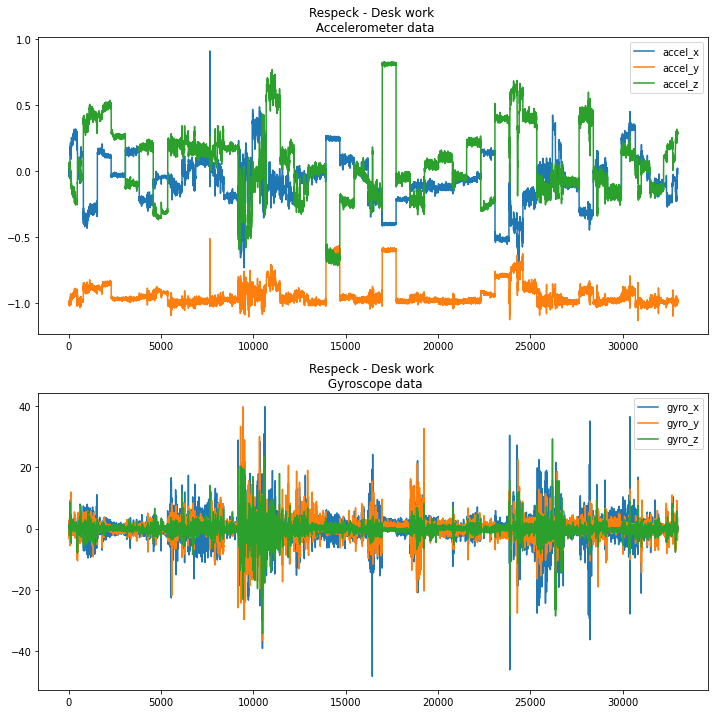

In [33]:
df_respeck = base_df[base_df.activity_type == 'Desk work'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

In [34]:
df_respeck = base_df[base_df.activity_type == 'Desk work'].reset_index(drop=True)
groups = []
for _, group in df_respeck.groupby('subject_id'):
    groups.append(group)
# compute average x and z accel deviations for the whole dataset
desk_deviations = []
for i in range(len(groups)):
    # print('Standard deviation is', np.std(groups[i]['accel_x']) + np.std(groups[i]['accel_z']))
    desk_deviations.append(np.std(groups[i]['accel_x']) + np.std(groups[i]['accel_z']))
np.mean(np.array(desk_deviations))

0.08290101817317731

In [35]:
print(len([x for x in desk_deviations if x > 0.04]))

28


Deviation is 0.13511267304674712


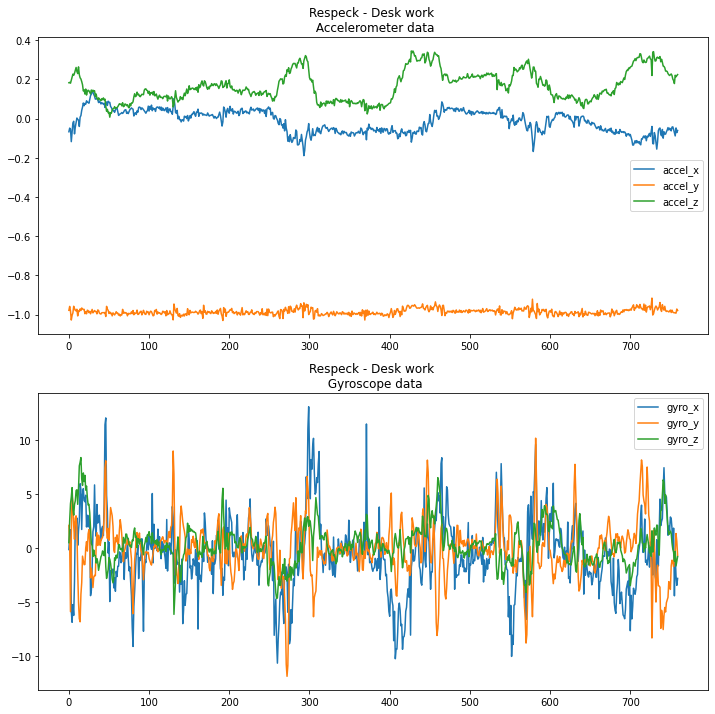

In [36]:
df_respeck = Kai_df[Kai_df.activity_type == 'Desk work'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

mean_accel_x = np.mean(df_respeck['accel_x'])
mean_accel_y = np.mean(df_respeck['accel_y'])
mean_accel_z = np.mean(df_respeck['accel_z'])

print('Deviation is', np.std(df_respeck['accel_x']) + np.std(df_respeck['accel_z']))

In [ ]:
########################## Movements superclass ########################################

In [53]:
def partial_sums(data):
    n = 10
    return np.array([sum(data[5*i:5*(i+2)]) for i in range(n)])

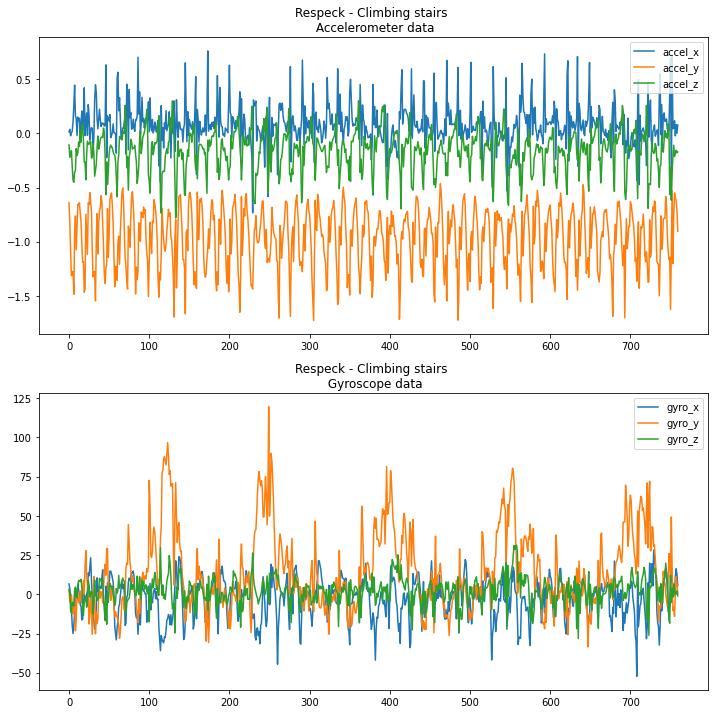

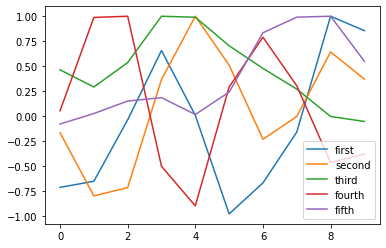

-0.06745536362316737
0.09877123536203199
0.46851014070467356
0.11943709070642335
0.39228307923960093


In [54]:
df_respeck = Kai_df[Kai_df.activity_type == 'Climbing stairs'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))
plt.figure()

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()

print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

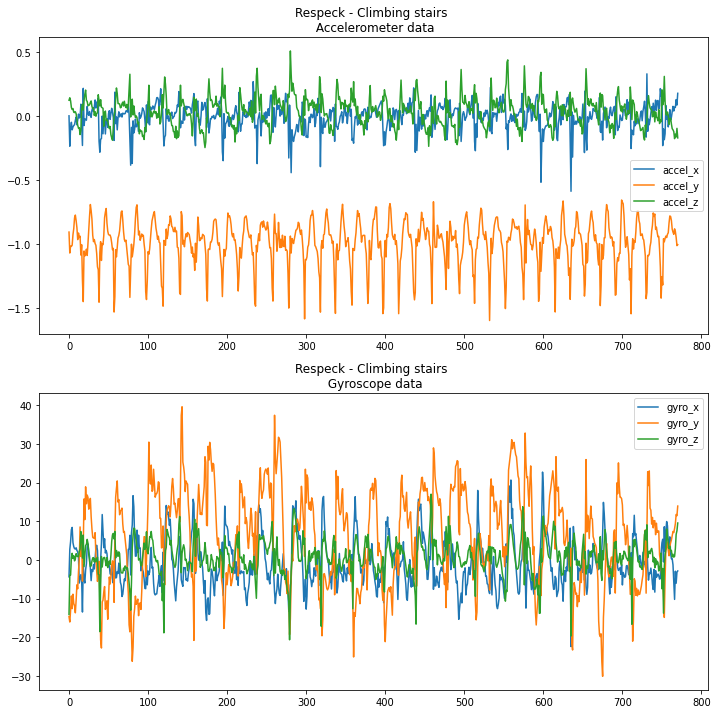

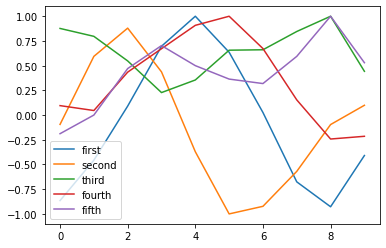

-0.08847951914514691
-0.10433514383423861
0.6409953550099534
0.35255922029303555
0.4293070565797839


In [39]:
df_respeck = pd.read_csv('Climbing_stairs.csv').reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")


# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))
    
sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()

print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

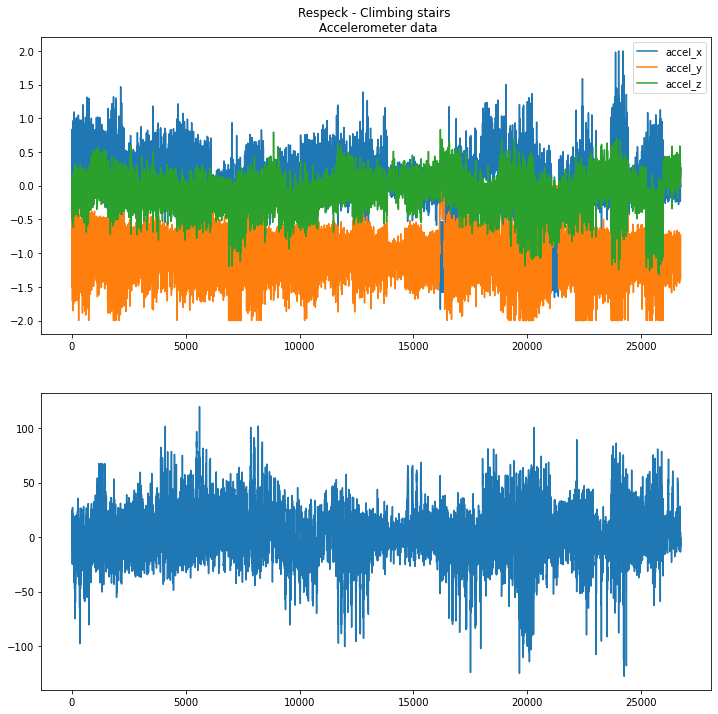

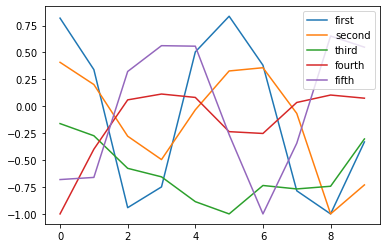

-0.09238459276683328
-0.13045097227968555
-0.61022775141116
-0.1414766462312001
-0.0299807969275084


In [40]:
df_respeck = base_df[base_df.activity_type == 'Climbing stairs'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()

print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

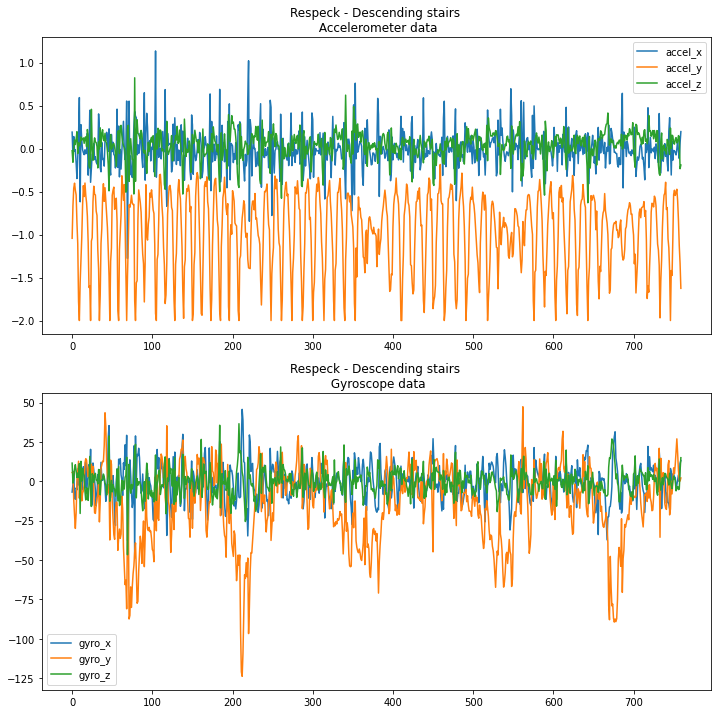

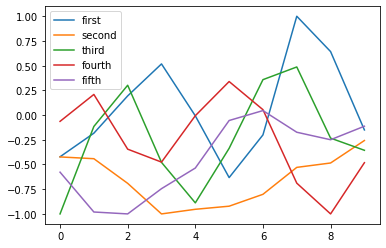

0.07584464793179665
-0.6503285348848873
-0.22606012343221185
-0.24583043560725804
-0.43836798895112405


In [41]:
df_respeck = Kai_df[Kai_df.activity_type == 'Descending stairs'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))


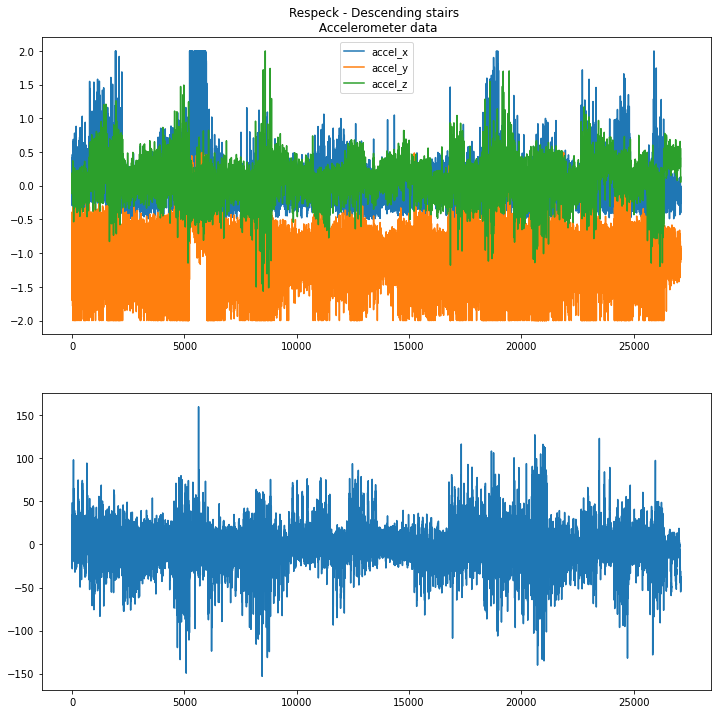

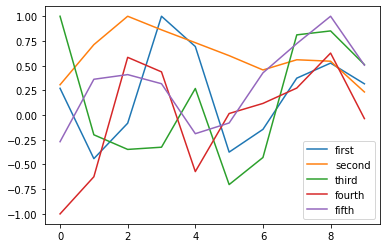

0.21380143112701253
0.6010337246831003
0.14386809929603556
-0.017582568178703593
0.3207600911458333


In [42]:
df_respeck = base_df[base_df.activity_type == 'Descending stairs'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_x'], label="accel_x")
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].plot(df_respeck['accel_z'], label="accel_z")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

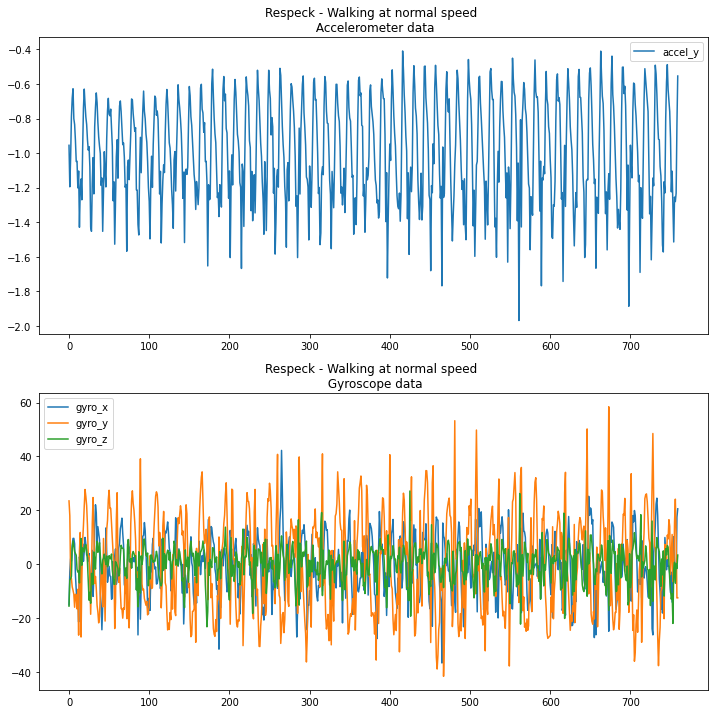

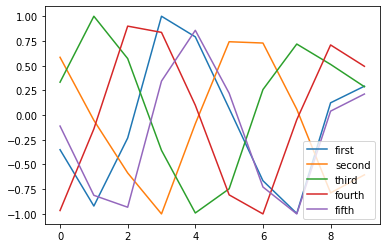

-0.08871454435727218
-0.10017916865742951
0.15877862595419848
0.007929639732856746
-0.1906708832166253
Std deviation of accel_y is 0.293009003121419


In [67]:
df_respeck = Kai_df[Kai_df.activity_type == 'Walking at normal speed'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

print('Std deviation of accel_y is', np.std(df_respeck['accel_y']))

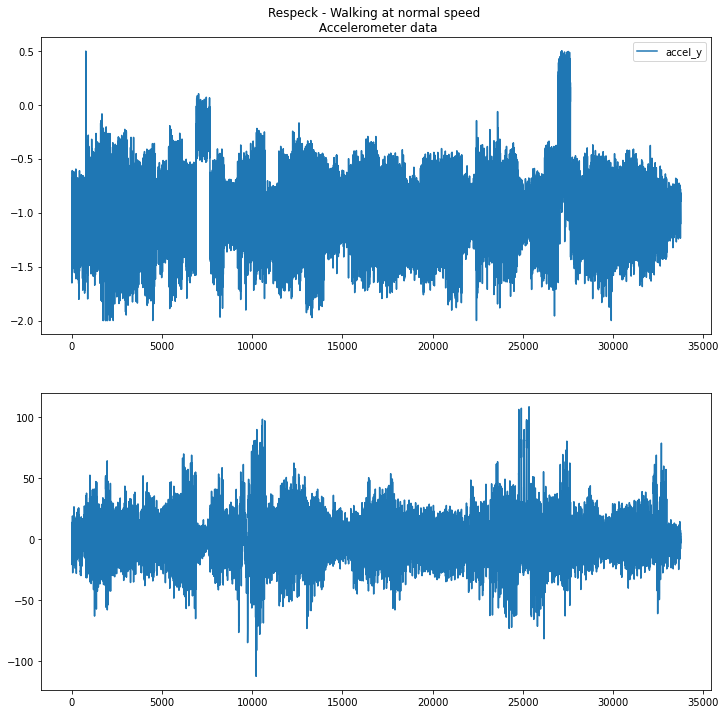

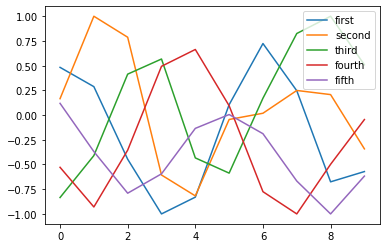

-0.16778595522845755
0.061826633852884894
0.12220357941834452
-0.28792008961911875
-0.4237526440214011


0.8814814814814815

In [62]:
df_respeck = base_df[base_df.activity_type == 'Walking at normal speed'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

means = np.abs(np.array([np.mean(np.array(sums[i])) for i in range(n)]))
len(means[means <= 0.33])/n

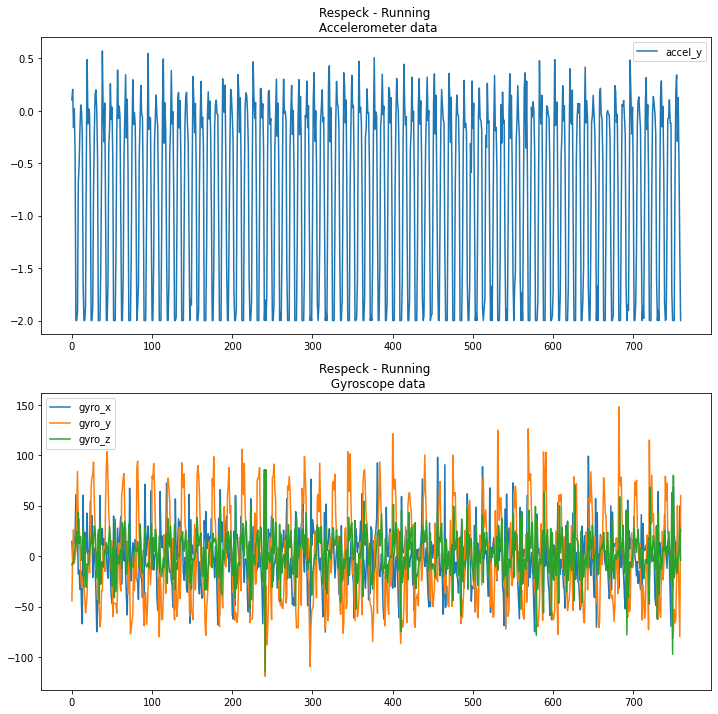

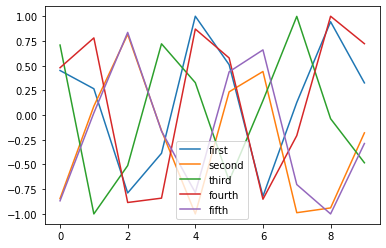

0.1628445292924472
-0.2524554367201426
0.020802609188882566
0.16465685818046372
-0.1848619054261403
Std deviation of accel_y is -0.805666231195342


0.2524554367201426

In [66]:
df_respeck = Kai_df[Kai_df.activity_type == 'Running'].reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_x'], label="gyro_x")
ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].plot(df_respeck['gyro_z'], label="gyro_z")
ax[1].legend()

ax[1].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Gyroscope data")

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

print('Std deviation of accel_y is', np.mean(df_respeck['accel_y']))

means = np.abs(np.array([np.mean(np.array(sums[i])) for i in range(n)]))
max(means)

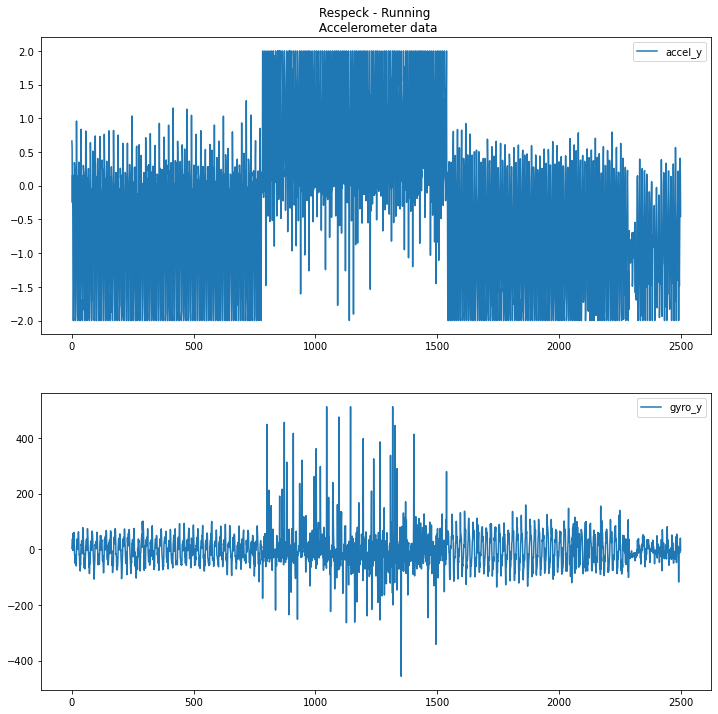

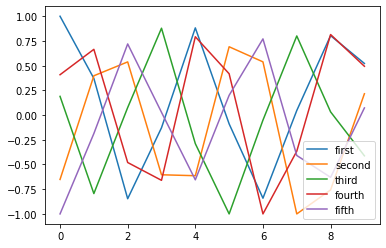

0.1720859612240131
-0.12443246064190658
-0.05689097453186933
0.10869691319660243
-0.10892053679721428


0.96

In [60]:
df_respeck = base_df[base_df.activity_type == 'Running'].reset_index(drop=True).head(2500)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# plot respeck
ax[0].plot(df_respeck['accel_y'], label="accel_y")
ax[0].legend()

ax[0].set_title(f"{df_respeck['sensor_type'].values[0]} - {df_respeck['activity_type'].values[0]} \n Accelerometer data")

ax[1].plot(df_respeck['gyro_y'], label="gyro_y")
ax[1].legend()

# compute the partial sums of gyro_y values

gyro_y = df_respeck['gyro_y']
sums = []
n = round(len(gyro_y)/50)
for i in range(n):
    sums.append(partial_sums(gyro_y[i*50:(i+1)*50]))

sums = np.asarray([sums[i]/max(np.abs(sums[i])) for i in range(n)])

plt.figure()
plt.plot(sums[0], label='first')
plt.plot(sums[1], label='second')
plt.plot(sums[2], label='third')
plt.plot(sums[3], label='fourth')
plt.plot(sums[4], label='fifth')
plt.legend(loc='best')
plt.show()


print(np.mean(np.array(sums[0])))
print(np.mean(np.array(sums[1])))
print(np.mean(np.array(sums[2])))
print(np.mean(np.array(sums[3])))
print(np.mean(np.array(sums[4])))

means = np.abs(np.array([np.mean(np.array(sums[i])) for i in range(n)]))
len(means[means <= 0.33])/n

In [69]:
walking_deviations = []
df_respeck = base_df[base_df.activity_type == 'Walking at normal speed'].reset_index(drop=True)
for _, group in df_respeck.groupby('subject_id'):
    walking_deviations.append(np.std(group['accel_y']))
np.array(walking_deviations)

array([0.3327972 , 0.31663221, 0.22591192, 0.32611335, 0.1497059 ,
       0.16735336, 0.24962208, 0.21071518, 0.39134485, 0.23962093,
       0.33593191, 0.38372125, 0.293009  , 0.26380629, 0.29103799,
       0.16976229, 0.26145374, 0.32956863, 0.1022115 , 0.22009817,
       0.40862783, 0.31975862, 0.32681955, 0.12665942, 0.19928834,
       0.29557042, 0.23921341, 0.25836992, 0.01382412, 0.11941866,
       0.27297953, 0.30260365, 0.37196212, 0.23014016, 0.28311015,
       0.21255944, 0.2865169 , 0.23976228, 0.16002394, 0.21961056,
       0.32447523, 0.11052183, 0.20090611, 0.30089866, 0.35613388])

In [70]:
np.max(walking_deviations)

0.4086278292324001

In [71]:
running_deviations = []
df_respeck = base_df[base_df.activity_type == 'Running'].reset_index(drop=True)
for _, group in df_respeck.groupby('subject_id'):
    running_deviations.append(np.std(group['accel_y']))
np.array(running_deviations)

array([0.92776811, 0.95924616, 0.85219   , 0.89541782, 0.84291944,
       0.9039403 , 0.81367835, 0.8886488 , 0.90507962, 0.92728134,
       0.79860683, 0.91624223, 0.89166244, 0.87754132, 0.84862886,
       0.75800167, 0.89743271, 0.89811962, 0.96232453, 0.86967293,
       0.97509864, 0.73902548, 0.92973461, 0.93914291, 0.93739666,
       0.88163596, 0.82418699, 0.97472103, 0.90406032, 0.85716169,
       0.86209109, 0.94424688, 0.95510805, 0.85912058, 0.86488521,
       0.74377869, 0.9079185 , 0.71643308, 0.869182  , 0.85854659,
       0.9848814 , 0.86874579, 0.8653702 , 0.98311976, 0.63042287])

In [72]:
np.min(running_deviations)

0.630422870520518

In [73]:
print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")

The data was collected using the sensors: ['Respeck']
The data was collected for the activities: ['Standing' 'Walking at normal speed' 'Climbing stairs' 'Desk work'
 'Sitting' 'Sitting bent forward' 'Sitting bent backward'
 'Lying down on back' 'Lying down on stomach' 'Lying down left'
 'Lying down right' 'Falling on the left' 'Falling on the right'
 'Falling on knees' 'Falling on the back' 'Running' 'Descending stairs']
The number of unique recordings is: 809
The subject IDs in the recordings are: 46


In [74]:
reduced_class_labels = {
    'Falling on the left':0,
    'Falling on knees':0,
    'Falling on the back':0,
    'Descending stairs':3,
    'Standing':1,
    'Lying down right':2,
    'Walking at normal speed':3,
    'Lying down on back':2,
    'Desk work':1,
    'Running':3,
    'Climbing stairs':3,
    'Falling on the right':0,
    'Sitting bent backward':1,
    'Sitting bent forward':1,
    'Lying down left':2,
    'Lying down on stomach':2,
    'Sitting':1
}

In [75]:
class_labels = {
    'Falling on the left':0,
    'Falling on knees':1,
    'Falling on the back':2,
    'Descending stairs':3,
    'Standing':4,
    'Lying down right':5,
    'Walking at normal speed':6,
    'Lying down on back':7,
    'Desk work':8,
    'Running':9,
    'Climbing stairs':10,
    'Falling on the right':11,
    'Sitting bent backward':12,
    'Sitting bent forward':13,
    'Lying down left':14,
    'Lying down on stomach':16,
    'Sitting':17
}

In [76]:
falling_class_labels = {
    0:0,
    11:1,
    2:2,
    1:3
}

falling_class_labels_inv = {
    0:0,
    1:11,
    2:2,
    3:1
}

In [77]:
sitting_standing_class_labels = {
    13:0,
    4:1,
    17:2,
    8:3,
    12:4
}

sitting_standing_class_labels_inv = {
    0:13,
    1:4,
    2:17,
    3:8,
    4:12
}

In [78]:
lying_class_labels = {
    16:0,
    7:1,
    14:2,
    5:3
}

lying_class_labels_inv = {
    0:16,
    1:7,
    2:14,
    3:5
}

In [79]:
moving_class_labels = {
    10:0,
    3:1,
    6:2,
    9:3
}

moving_class_labels_inv = {
    0:10,
    1:3,
    2:6,
    3:9
}

In [80]:
len(final_sliding_windows)

1163900

In [81]:
n

15

In [82]:
# randomly select five partitions and train the model on them
random_partitions = [4, 16, 27, 31, 40]

In [83]:
# get the training and testing features
feature_lists_train = []
feature_lists_test = []

In [84]:
for i in random_partitions:
    print(i)
    # now extract all features
    feature_list = []

    for col in columns_of_interest:
        new_features = tsfresh.extract_features(timeseries_container=training_partitions[i], column_id='window_id',
                            column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters(), n_jobs=8)
        feature_list.append(new_features)

    feature_list = pd.concat(feature_list, axis=1)
    
    feature_lists_train.append(feature_list)

4


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


16


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


27


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 10.39it/s]


31


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


40


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 10.43it/s]


In [85]:
for i in random_partitions:
    print(i)
    # now extract all features
    feature_list = []

    for col in columns_of_interest:
        new_features = tsfresh.extract_features(timeseries_container=testing_partitions[i], column_id='window_id',
                            column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters(), n_jobs=8)
        feature_list.append(new_features)

    feature_list = pd.concat(feature_list, axis=1)
    
    feature_lists_test.append(feature_list)

4


Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 417.91it/s]

16



Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 448.35it/s]

27



Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 455.00it/s]

31



Feature Extraction: 100%|██████████| 37/37 [00:00<00:00, 413.36it/s]

40



Feature Extraction: 100%|██████████| 38/38 [00:00<00:00, 480.70it/s]


In [86]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D

In [87]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 4
window_size

50

In [88]:
# An LSTM model
'''
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
'''

"\nmodel = Sequential()\nmodel.add(LSTM(100, input_shape=(window_size, n_features)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nmodel.summary()\n"

In [89]:
# the CNN model
'''
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.SGD(lr=0.01, momentum=0.5),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

model.summary()
'''

"\nmodel = Sequential()\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', \n                 input_shape=(window_size, n_features)))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(activation))\n\nmodel.add(Flatten())\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\n\nmodel.compile(\n    optimizer=optimizers.SGD(lr=0.01, momentum=0.5),\n    loss='categorical_crossentropy',\n    metrics = ['accuracy'])\n\nmodel.summary()\n"

In [90]:
X_train = []
y_train = []
y_train_reduced = []

for window_id, group in training_partitions[16].groupby('window_id'):
    # print(f"window_id = {window_id}")
    shape = group[columns_of_interest].values.shape
    # print(f"shape = {shape}")    
    X_train.append(group[columns_of_interest].values)
    y_train.append(class_labels[group["activity_type"].values[0]])
    y_train_reduced.append(reduced_class_labels[group["activity_type"].values[0]])
    
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
y_train_reduced = np.asarray(y_train_reduced)

print(f"X train shape = {X_train.shape}")
print(f"y train shape = {y_train.shape}")

X train shape = (22869, 50, 6)
y train shape = (22869,)


In [91]:
falling_indices = [j for j in range(len(y_train)) if (y_train[j]==0 or y_train[j]==1 or y_train[j]==2 or y_train[j]==11)]
X_train_falling  = np.asarray([X_train[j] for j in falling_indices])
y_train_falling = np.asarray([y_train[j] for j in falling_indices])


In [92]:
sitting_standing_indices = [j for j in range(len(y_train)) if (y_train[j]==4 or y_train[j]==8 or y_train[j]==12 or y_train[j]==13 or y_train[j]==17)]
X_train_sitting_standing = np.asarray([X_train[j] for j in sitting_standing_indices])
y_train_sitting_standing = np.asarray([y_train[j] for j in sitting_standing_indices])


In [93]:
lying_indices = [j for j in range(len(y_train)) if (y_train[j]==5 or y_train[j]==7 or y_train[j]==14 or y_train[j]==16)]
X_train_lying = np.asarray([X_train[j] for j in lying_indices])
y_train_lying = np.asarray([y_train[j] for j in lying_indices])


In [94]:
moving_indices = [j for j in range(len(y_train)) if (y_train[j]==3 or y_train[j]==6 or y_train[j]==9 or y_train[j]==10 or y_train[j]==15)]
X_train_moving = np.asarray([X_train[j] for j in moving_indices])
y_train_moving = np.asarray([y_train[j] for j in moving_indices])


In [95]:
print(len(falling_indices))
print(len(sitting_standing_indices))
print(len(lying_indices))
print(len(moving_indices))

4361
5951
5295
7262


In [96]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17}

In [97]:
y_train_falling = np.asarray([falling_class_labels[y_train_falling[j]] for j in range(len(y_train_falling))])

y_train_sitting_standing = np.asarray([sitting_standing_class_labels[y_train_sitting_standing[j]] for j in range(len(y_train_sitting_standing))])

y_train_lying = np.asarray([lying_class_labels[y_train_lying[j]] for j in range(len(y_train_lying))])

y_train_moving = np.asarray([moving_class_labels[y_train_moving[j]] for j in range(len(y_train_moving))])

In [98]:
# Use Kai's data for testing

X_test = []
y_test = []
y_test_reduced = []


for window_id, group in Kai_final_sliding_windows.groupby('window_id'):
    # print(f"window_id = {window_id}")
    shape = group[columns_of_interest].values.shape
    # print(f"shape = {shape}")    
    X_test.append(group[columns_of_interest].values)
    y_test.append(class_labels[group["activity_type"].values[0]])
    y_test_reduced.append(reduced_class_labels[group["activity_type"].values[0]])

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_reduced = np.array(y_test_reduced)

print(f"X test shape = {X_test.shape}")
print(f"y test shape = {y_test.shape}")

X test shape = (431, 50, 6)
y test shape = (431,)


In [99]:
'''
n_steps, n_length = 2, 25
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

# A CNN-LSTM model

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, input_shape=(window_size, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
'''

"\nn_steps, n_length = 2, 25\nX_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))\nX_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))\n\n# A CNN-LSTM model\n\nmodel = Sequential()\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))\nmodel.add(TimeDistributed(Dropout(0.5)))\nmodel.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel.add(TimeDistributed(Flatten()))\nmodel.add(LSTM(100, input_shape=(window_size, n_features)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dense(n_classes, activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nmodel.summary()\n"

In [100]:
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 2, 25
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

# the ConvLSTM Network Model for the top hierarchy

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 23, 64)         54016     
_________________________________________________________________
dropout (Dropout)            (None, 1, 23, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               147300    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 201,720
Trainable params: 201,720
Non-trainable params: 0
_________________________________________________________________


In [101]:
n_classes

4

In [102]:
def OHE(num, n_classes):
    return ([0 for x in range(num)] + [1] + [0 for x in range(n_classes - num - 1)])

In [103]:
def get_OHE(l, n_classes):
    return ([OHE(x, n_classes) for x in l])

In [104]:
y_train_reduced = get_OHE(y_train_reduced, n_classes)

In [105]:
y_train_reduced = np.asarray(y_train_reduced, dtype=float)

In [106]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train_reduced.shape}")

X_train shape = (22869, 2, 1, 25, 6)
y_train shape = (22869, 4)


In [107]:
# fit network
model.fit(X_train, y_train_reduced, epochs=5, batch_size=128)

Epoch 1/5
179/179 [==============================] - 11s 39ms/step - loss: 0.8892 - accuracy: 0.6887
Epoch 2/5
179/179 [==============================] - 11s 63ms/step - loss: 0.0780 - accuracy: 0.9773
Epoch 3/5
179/179 [==============================] - 9s 51ms/step - loss: 0.0552 - accuracy: 0.9817
Epoch 4/5
179/179 [==============================] - 22s 122ms/step - loss: 0.0457 - accuracy: 0.9848
Epoch 5/5
179/179 [==============================] - 15s 83ms/step - loss: 0.0342 - accuracy: 0.9891


In [108]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_pred_labels.shape

(431,)

In [109]:
accuracy = accuracy_score(y_test_reduced, y_pred_labels)
accuracy

1.0

In [110]:
X_train_fallings = [X_train_falling for _ in range(5)]
X_train_falling_concat = np.concatenate(X_train_fallings)
y_train_fallings = [y_train_falling for _ in range(5)]
y_train_falling_concat = np.concatenate(y_train_fallings)

X_train_sitting_standings = [X_train_sitting_standing for _ in range(5)]
X_train_sitting_standing_concat = np.concatenate(X_train_sitting_standings)
y_train_sitting_standings = [y_train_sitting_standing for _ in range(5)]
y_train_sitting_standing_concat = np.concatenate(y_train_sitting_standings)

X_train_lyings = [X_train_lying for _ in range(5)]
X_train_lying_concat = np.concatenate(X_train_lyings)
y_train_lyings = [y_train_lying for _ in range(5)]
y_train_lying_concat = np.concatenate(y_train_lyings)

X_train_movings = [X_train_moving for _ in range(5)]
X_train_moving_concat = np.concatenate(X_train_movings)
y_train_movings = [y_train_moving for _ in range(5)]
y_train_moving_concat = np.concatenate(y_train_movings)

In [111]:
pred_falling_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==0)]
pred_sitting_standing_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==1)]
pred_lying_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==2)]
pred_moving_indices = [j for j in range(len(y_pred_labels)) if (y_pred_labels[j]==3)]

In [138]:
# reconstruct the original labels
y_pred_orig_labels = np.zeros(shape=(len(y_pred_labels),), dtype=int)

In [139]:
X_pred_falling = np.array([X_test[j] for j in pred_falling_indices])
X_pred_falling.shape

(54, 2, 1, 25, 6)

In [140]:
X_pred_sitting_standing = np.array([X_test[j] for j in pred_sitting_standing_indices])
X_pred_sitting_standing.shape

(145, 2, 1, 25, 6)

In [141]:
X_pred_lying = np.array([X_test[j] for j in pred_lying_indices])
X_pred_lying.shape

(116, 2, 1, 25, 6)

In [142]:
X_pred_moving = np.array([X_test[j] for j in pred_moving_indices])
X_pred_moving.shape

(116, 2, 1, 25, 6)

In [143]:
# develop model for distinguishing lying types

def predict_lying_category(X_test):
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3], X_test.shape[4])
    X_test_means = np.mean(X_test, axis=1)
    y_pred = np.zeros(shape=(X_test.shape[0],), dtype=int)
    for i in range(X_test_means.shape[0]):
        accel_x, accel_y, accel_z = X_test_means[i][0], X_test_means[i][1], X_test_means[i][2]
        accel_norm = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
        cos_theta_z = accel_z/accel_norm
        theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
        if theta_z >= 0.0 and theta_z <= 45.0:
            y_pred[i] = 1 # on back
        elif theta_z > 45.0 and theta_z <= 90.0:
            y_pred[i] = 3 # on right
        elif theta_z > 90.0 and theta_z <= 135.0:
            y_pred[i] = 2 # on left
        elif theta_z > 135.0 and theta_z <= 180.0:
            y_pred[i] = 0 # on stomach
        else:
            y_pred[i] = 1 # default is on back
    return y_pred


In [144]:
y_pred_lying_labels = predict_lying_category(X_pred_lying)

In [145]:
y_pred_lying_orig_labels = [lying_class_labels_inv[y_pred_lying_labels[j]] for j in range(len(y_pred_lying_labels))]
for j in range(len(y_pred_lying_labels)):
    y_pred_orig_labels[pred_lying_indices[j]] = y_pred_lying_orig_labels[j]

In [146]:
y_pred_orig_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [147]:
y_test

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [148]:
def setup_falling_model(n_classes=4, X_train_falling=X_train_falling_concat, y_train_falling=y_train_falling_concat):
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 2, 25
    X_train_falling = X_train_falling.reshape((X_train_falling.shape[0], n_steps, 1, n_length, n_features))
    
    # the ConvLSTM Network Model for the 'falling' class
    falling_model = Sequential()
    falling_model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    falling_model.add(Dropout(0.5))
    falling_model.add(Flatten())
    falling_model.add(Dense(100, activation='relu'))
    falling_model.add(Dense(n_classes, activation='softmax'))
    falling_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    y_train_falling = np.asarray(get_OHE(y_train_falling, n_classes), dtype=np.float32)
    
    falling_model.fit(X_train_falling, y_train_falling, epochs=5, batch_size=64)
    return falling_model

In [149]:
falling_model = setup_falling_model()

if len(X_pred_falling != 0):
    y_pred_falling_ohe = falling_model.predict(X_pred_falling)
    y_pred_falling_labels = np.argmax(y_pred_falling_ohe, axis=1)
    # convert labels back to original
    y_pred_falling_orig_labels = [falling_class_labels_inv[y_pred_falling_labels[j]] for j in range(len(y_pred_falling_labels))]
    # print(np.asarray(y_pred_falling_orig_labels))
    for j in range(len(y_pred_falling_labels)):
        y_pred_orig_labels[pred_falling_indices[j]] = y_pred_falling_orig_labels[j]

Epoch 1/5
341/341 [==============================] - 17s 42ms/step - loss: 0.5183 - accuracy: 0.8865
Epoch 2/5
341/341 [==============================] - 13s 38ms/step - loss: 0.0119 - accuracy: 0.9972
Epoch 3/5
341/341 [==============================] - 39s 113ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 4/5
341/341 [==============================] - 22s 63ms/step - loss: 0.0025 - accuracy: 0.9991
Epoch 5/5
341/341 [==============================] - 19s 55ms/step - loss: 0.0099 - accuracy: 0.9980


In [150]:
y_pred_orig_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [151]:
y_test

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [152]:
# develop model for distinguishing sitting_standing types

def predict_sitting_standing_category(X_test):
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3], X_test.shape[4])
    y_pred = np.zeros(shape=(X_test.shape[0],), dtype=int)
    for i in range(X_test.shape[0]):
        df = X_test[i]
        accel_x_arr, accel_y_arr, accel_z_arr = df[:, 0], df[:, 1], df[:, 2]
        gyro_x_arr, gyro_y_arr, gyro_z_arr = df[:, 3], df[:, 4], df[:, 5]
        mean_accel_x, mean_accel_y, mean_accel_z = np.mean(accel_x_arr), np.mean(accel_y_arr), np.mean(accel_z_arr)
        accel_deviations = np.std(accel_x_arr) + np.std(accel_z_arr) # lateral movements
        cos_theta_z = mean_accel_z/np.sqrt(mean_accel_x**2 + mean_accel_y**2 + mean_accel_z**2)
        theta_z = np.arccos(cos_theta_z) * 180/np.pi # get angle in degrees
        
        filtered_gyro_y = np.array([abs(gyro_y_arr[i]) for i in range(len(gyro_y_arr)) if abs(gyro_y_arr[i]) < 10.0])
        SMA_y = sum(filtered_gyro_y)/len(filtered_gyro_y)
        
        if accel_deviations > 0.04:
            y_pred[i] = 3 # desk work
        else:
            if theta_z > 85.0 and theta_z < 95.0:
                if SMA_y <= 0.85:
                    y_pred[i] = 2 # sitting
                else:
                    y_pred[i] = 1 # standing
            elif theta_z >= 0.0 and theta_z <= 85.0:
                y_pred[i] = 4 # sitting bent backward
            elif theta_z >= 95.0 and theta_z <= 180.0:
                y_pred[i] = 0 # sitting bent forward
            else:
                y_pred[i] = 3 # default is desk work
    return y_pred


In [153]:
y_pred_sitting_standing_labels = predict_sitting_standing_category(X_pred_sitting_standing)

In [154]:
y_pred_sitting_standing_orig_labels = [sitting_standing_class_labels_inv[y_pred_sitting_standing_labels[j]] for j in range(len(y_pred_sitting_standing_labels))]
for j in range(len(y_pred_sitting_standing_labels)):
    y_pred_orig_labels[pred_sitting_standing_indices[j]] = y_pred_sitting_standing_orig_labels[j]

In [155]:
y_pred_orig_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  8,  8,  8, 12,  8,  8, 12, 12, 12,  8,
        8,  8,  8, 17, 17,  8,  8,  8,  8, 12,  8,  8,  8,  8, 12,  8,  8,
        8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [156]:
y_test

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [200]:
# develop model for distinguishing movement types

def predict_moving_category(X_test):
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3], X_test.shape[4])
    y_pred = np.zeros(shape=(X_test.shape[0],), dtype=int)
    for i in range(X_test.shape[0]):
        df = X_test[i]
        accel_y_arr = df[:, 1]
        gyro_y_arr = df[:, 4]
        sums = partial_sums(gyro_y_arr)
        normalised_sums = sums/max(np.abs(sums))
        average_area = round(np.mean(normalised_sums), 3)
        accel_y_std = np.std(accel_y_arr)
        if np.abs(average_area) >= 0.33:
            if average_area < 0:
                y_pred[i] = 1 # descending stairs
            else:
                y_pred[i] = 0 # ascending stairs
        else:
            if accel_y_std >= 0.5:
                y_pred[i] = 3 # running
            else:
                y_pred[i] = 2 # walking at normal speed
    return y_pred


In [201]:
# reconstruct the original labels
y_pred_orig_labels = np.zeros(shape=(len(y_pred_labels),), dtype=int)

In [202]:
y_pred_moving_labels = predict_moving_category(X_pred_moving)

In [203]:
y_pred_moving_orig_labels = [moving_class_labels_inv[y_pred_moving_labels[j]] for j in range(len(y_pred_moving_labels))]
for j in range(len(y_pred_moving_labels)):
    y_pred_orig_labels[pred_moving_indices[j]] = y_pred_moving_orig_labels[j]

In [204]:
y_pred_orig_labels

array([ 6,  6,  6, 10, 10,  6,  6,  6, 10, 10,  6,  6,  6,  6, 10, 10, 10,
        6,  6,  6, 10, 10, 10,  6,  6,  6, 10, 10, 10,  6,  6,  3,  3,  6,
        9,  9,  3,  3,  6,  6,  9,  3,  3,  3,  6,  6,  9,  9,  3,  3,  3,
        6,  6,  6,  6,  3,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [205]:
y_test

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16